<a href="https://colab.research.google.com/github/Bionerdess/NMA2021/blob/ALedits/NMA2021_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neuromatch Academy 2021
### Collaborative Project analyzing data by Steinmetz et. al., 2019
By Anna-Lena Schlenner, Shira Lupkin, Katrina Lee Bartas and Joaquin Herrero

In [26]:
#@title Necesssary imports
from scipy import stats, io
import numpy as np
import os, requests
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_style(style='whitegrid',rc={'grid.linewidth': 2})

from matplotlib import rcParams 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, LogisticRegressionCV
import pandas as pd
import pickle

import warnings
from sklearn.exceptions import ConvergenceWarning, DataConversionWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning,
                        module="sklearn")
warnings.filterwarnings("ignore", category=DataConversionWarning,
                        module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning,
                        module="statsmodels")
warnings.filterwarnings("ignore", category=FutureWarning,
                        module="pandas")

In [2]:
#@title Data loading
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [3]:
#@title Retrieve relevant data

vis_ses=[]

for s in range(len(alldat)):
  dat=alldat[s]
  if 'VISp' in dat['brain_area']:
    vis_ses.append(s)

alldat = alldat[vis_ses]

variables = [['spks'],['brain_area'],['reaction_time'],['response_time'], 
             ['response'],['contrast_left'],['contrast_right'],['feedback_type'],['bin_size']]
dd = np.array([])

for s in range(alldat.shape[0]):

  newdat = dict()
  dat = alldat[s]

  for key in dat:
    if  np.isin(key,variables):
      newdat[key] = dat[key]
  dd = np.hstack((dd,newdat))

print('Number of sessions with VISp recordings: {}'.format(dd.shape[0]))

Number of sessions with VISp recordings: 12


In [4]:
#@title Extract VISp FR for each contrast level
visDat00 = np.empty((dd.shape[0],250))
visDat25 = np.empty((dd.shape[0],250))
visDat05 = np.empty((dd.shape[0],250))
visDat1 = np.empty((dd.shape[0],250))

for s in range(dd.shape[0]):
  roi = dd[s]['brain_area']
  spks = dd[s]['spks'][roi=='VISp']
  contrast_right = dd[s]['contrast_right']
  visDat00[s] = spks[:,contrast_right==0.0,:].mean(axis=(0,1))
  visDat25[s] = spks[:,contrast_right==0.25,:].mean(axis=(0,1))
  visDat05[s] = spks[:,contrast_right==0.5,:].mean(axis=(0,1))
  visDat1[s] = spks[:,contrast_right==1.0,:].mean(axis=(0,1))


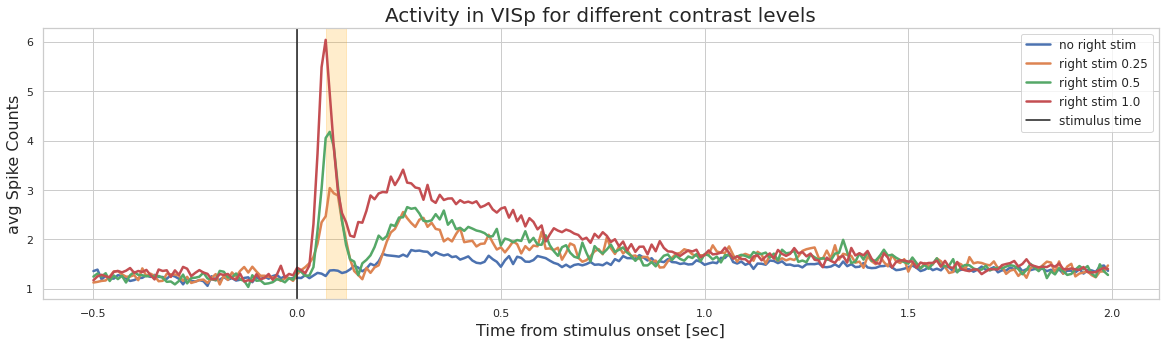

In [5]:
#@title Plot VISp across contrast levels

# can add shaded SEM around each contrast line
addSEM = 0

if addSEM==1:
  semVis = np.empty((4,250))
  semVis[0] = 1/bins * (np.std(visDat00,axis=0)/np.sqrt(visDat00.shape[0]))
  semVis[1] = 1/bins * (np.std(visDat25,axis=0)/np.sqrt(visDat25.shape[0]))
  semVis[2] = 1/bins * (np.std(visDat05,axis=0)/np.sqrt(visDat05.shape[0]))
  semVis[3] = 1/bins * (np.std(visDat1,axis=0)/np.sqrt(visDat1.shape[0]))

bins = dd[0]['bin_size']
x = np.arange(-.5,2.0,bins)
meanVis = np.empty((4,250))

meanVis[0] = 1/bins * visDat00.mean(axis=0)
meanVis[1] = 1/bins * visDat25.mean(axis=0)
meanVis[2] = 1/bins * visDat05.mean(axis=0)
meanVis[3] = 1/bins * visDat1.mean(axis=0)

plt.figure(figsize=(20,5))
plt.plot(x,meanVis[0],linewidth=2.5)
plt.plot(x,meanVis[1],linewidth=2.5)
plt.plot(x,meanVis[2],linewidth=2.5)
plt.plot(x,meanVis[3],linewidth=2.5)

if addSEM==1:
  plt.fill_between(x,meanVis[0]-semVis[0],meanVis[0]+semVis[0],alpha=0.3)
  plt.fill_between(x,meanVis[1]-semVis[1],meanVis[1]+semVis[1],alpha=0.3)
  plt.fill_between(x,meanVis[2]-semVis[2],meanVis[2]+semVis[2],alpha=0.3)
  plt.fill_between(x,meanVis[3]-semVis[3],meanVis[3]+semVis[3],alpha=0.3)

plt.axvline(0,color='k')
plt.axvspan(0.07, .12, color='orange', alpha=0.2)
plt.legend(['no right stim','right stim 0.25','right stim 0.5','right stim 1.0', 'stimulus time'], fontsize=12)
plt.xlabel('Time from stimulus onset [sec]',size=16)
plt.ylabel('avg Spike Counts',size=16)
plt.title('Activity in VISp for different contrast levels',size=20)
plt.show()

In [6]:
#@title Extract VISp FR for each motor response
motDat_l = np.empty((dd.shape[0],250))
motDat_r = np.empty((dd.shape[0],250))
motDat_no = np.empty((dd.shape[0],250))

for s in range(dd.shape[0]):
  roi = dd[s]['brain_area']
  spks = dd[s]['spks'][roi=='VISp']
  response = dd[s]['response']
  motDat_l[s] = spks[:,response==1,:].mean(axis=(0,1))
  motDat_r[s] = spks[:,response==-1,:].mean(axis=(0,1))
  motDat_no[s] = spks[:,response==0,:].mean(axis=(0,1))


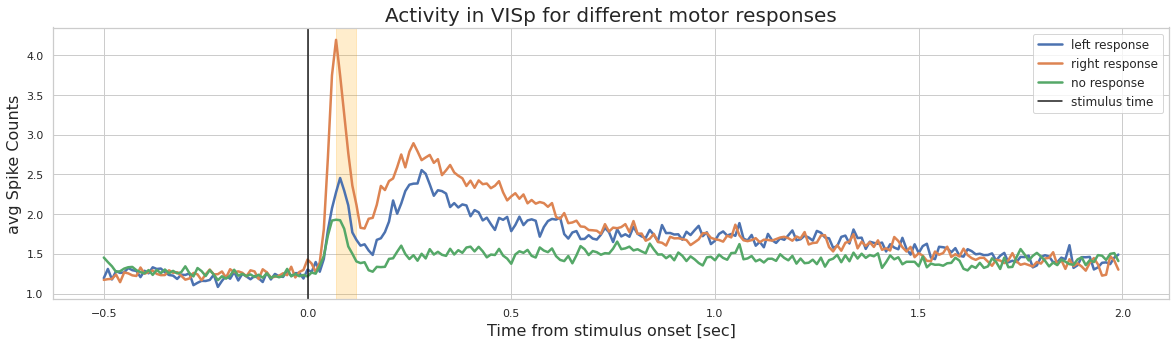

In [7]:
#@title Plot VISp across motor responses

# can add shaded SEM around each contrast line
addSEM = 0

if addSEM==1:
  semMot = np.empty((3,250))
  semMot[0] = 1/bins * (np.std(motDat_l,axis=0)/np.sqrt(motDat_l.shape[0]))
  semMot[1] = 1/bins * (np.std(motDat_r,axis=0)/np.sqrt(motDat_r.shape[0]))
  semMot[2] = 1/bins * (np.std(motDat_no,axis=0)/np.sqrt(motDat_no.shape[0]))

bins = dd[0]['bin_size']
x = np.arange(-.5,2.0,bins)
meanMot = np.empty((3,250))

meanMot[0] = 1/bins * motDat_l.mean(axis=0)
meanMot[1] = 1/bins * motDat_r.mean(axis=0)
meanMot[2] = 1/bins * motDat_no.mean(axis=0)

plt.figure(figsize=(20,5))
plt.plot(x,meanMot[0],linewidth=2.5)
plt.plot(x,meanMot[1],linewidth=2.5)
plt.plot(x,meanMot[2],linewidth=2.5)

if addSEM==1:
  plt.fill_between(x,meanMot[0]-semMot[0],meanMot[0]+semMot[0],alpha=0.3)
  plt.fill_between(x,meanMot[1]-semMot[1],meanMot[1]+semMot[1],alpha=0.3)
  plt.fill_between(x,meanMot[2]-semMot[2],meanMot[2]+semMot[2],alpha=0.3)

plt.axvline(0,color='k')
plt.axvspan(0.07, .12, color='orange', alpha=0.2)
plt.legend(['left response','right response','no response', 'stimulus time'], fontsize=12)
plt.xlabel('Time from stimulus onset [sec]',size=16)
plt.ylabel('avg Spike Counts',size=16)
plt.title('Activity in VISp for different motor responses',size=20)
plt.show()

In [8]:
dfVis = np.concatenate([visDat00,visDat25,visDat05,visDat1])

nSess = dd.shape[0]
nContrast = int(dfVis.shape[0]/nSess)

contrast = np.zeros((int(nSess*nContrast),1))
for i in range(1,nContrast):
  contrast[i*nSess:i*nSess+nSess] = i


In [9]:
#@title Run PCA contrast levels

pca = PCA(n_components=4)

PC = pca.fit_transform(dfVis)

pdPC =pd.DataFrame(PC,columns=['PC1','PC2','PC3','PC4'])
pdPC['contrast'] = contrast
pdPC['contrast'] = pdPC['contrast'].map({0.0: 0.0,1.0: 0.25,2.0: 0.5,3.0: 1.0})



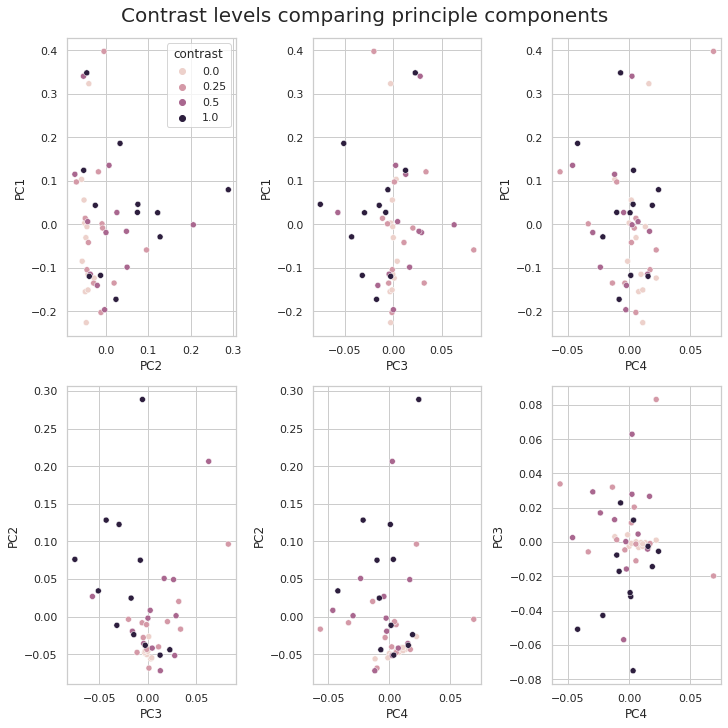

In [10]:
fig, axes = plt.subplots(2,3,figsize=(10,10),constrained_layout=True) # ,figsize=(40,40)
fig.suptitle('Contrast levels comparing principle components',size=20)
sns.scatterplot(data = pdPC,x='PC2',y='PC1',ax=axes[0,0],hue=pdPC['contrast'],legend='full') # 
sns.scatterplot(data = pdPC,x='PC3',y='PC1',ax=axes[0,1],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC1',ax=axes[0,2],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC3',y='PC2',ax=axes[1,0],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC2',ax=axes[1,1],hue=pdPC['contrast'],legend=False)
sns.scatterplot(data = pdPC,x='PC4',y='PC3',ax=axes[1,2],hue=pdPC['contrast'],legend=False)


In [11]:
dfMot = np.concatenate([motDat_l,motDat_r,motDat_no])

nSess = dd.shape[0]
nMot = int(dfMot.shape[0]/nSess)

mResp = np.zeros((int(nSess*nMot),1))
for i in range(1,nMot):
  mResp[i*nSess:i*nSess+nSess] = i

In [12]:
#@title Run PCA motor responses

pca = PCA(n_components=4)

PC = pca.fit_transform(dfMot)

pdPC2 =pd.DataFrame(PC,columns=['PC1','PC2','PC3','PC4'])
pdPC2['mResp'] = mResp
pdPC2['mResp'] = pdPC2['mResp'].map({0.0: 0.0,1.0: 0.25,2.0: 0.5,3.0: 1.0})


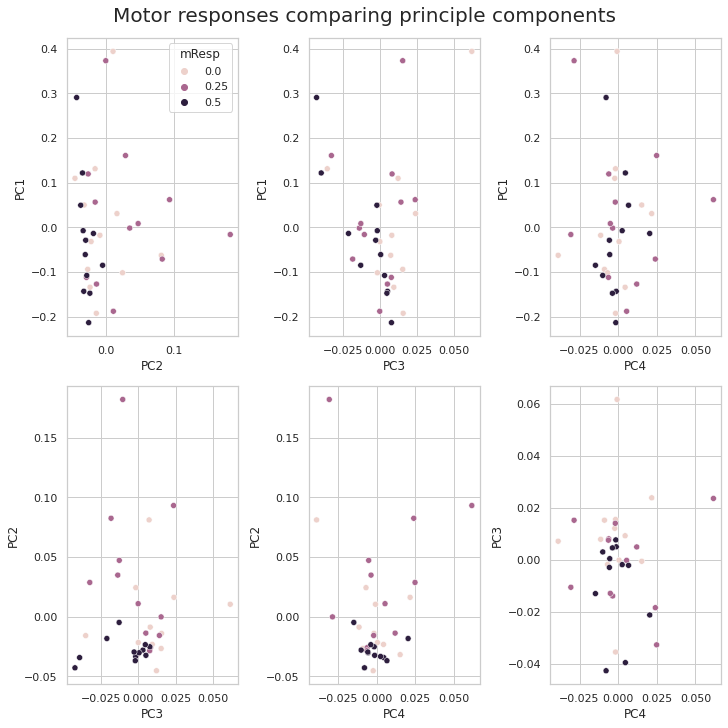

In [13]:
fig, axes = plt.subplots(2,3,figsize=(10,10),constrained_layout=True) # ,figsize=(40,40)
fig.suptitle('Motor responses comparing principle components',size=20)
sns.scatterplot(data = pdPC2,x='PC2',y='PC1',ax=axes[0,0],hue=pdPC2['mResp'],legend='full') # 
sns.scatterplot(data = pdPC2,x='PC3',y='PC1',ax=axes[0,1],hue=pdPC2['mResp'],legend=False)
sns.scatterplot(data = pdPC2,x='PC4',y='PC1',ax=axes[0,2],hue=pdPC2['mResp'],legend=False)
sns.scatterplot(data = pdPC2,x='PC3',y='PC2',ax=axes[1,0],hue=pdPC2['mResp'],legend=False)
sns.scatterplot(data = pdPC2,x='PC4',y='PC2',ax=axes[1,1],hue=pdPC2['mResp'],legend=False)
sns.scatterplot(data = pdPC2,x='PC4',y='PC3',ax=axes[1,2],hue=pdPC2['mResp'],legend=False)

## Decoding contrast levels from spiking data in the primary visual cortex (VISp)

In [27]:
#@title Remove neurons with firing rate <0.1 Hz during the first 150ms after stimulus presentation
# initialize model
contrast_decoderL = LassoCV(cv=10,random_state=42,max_iter=10000)
contrast_decoderR = LassoCV(cv=10,random_state=43,max_iter=10000)

decoder = pd.DataFrame([])

for s in range(dd.shape[0]): # 
  print('decoding data from session {0}/{1}'.format(s+1,dd.shape[0]))
  roi = dd[s]['brain_area']
  spks = dd[s]['spks'][roi=='VISp']
  mean_fr = (1/bins* spks[:,:,50:200]).mean(axis=(1,2))
  keep_idx = mean_fr >= 0.1
  good_cells = spks[keep_idx,:]

  visSpks = good_cells[:,:,57:62].sum(axis=2) #70-120ms from stim = 7 10ms bins plus 50 bins from data start
  visSpks = visSpks-visSpks.mean() # mean center the data
  contrast_right = dd[s]['contrast_right']
  contrast_left = dd[s]['contrast_left']
  
  s_train, s_test, cR_train, cR_test, cL_train, cL_test = train_test_split(visSpks.T,contrast_right,contrast_left,test_size=0.5,shuffle=True)
  vLeft = contrast_decoderL.fit(s_train,cL_train)
  vRight = contrast_decoderR.fit(s_train,cR_train)
  
  vL_hat = vLeft.predict(s_test)
  vR_hat = vRight.predict(s_test)

  decoder
  
  print('Proportion of non-zero cells for left decoder: %f' %((vLeft.coef_!=0).sum()/vLeft.coef_.shape[0]))
  print('Proportion of non-zero cells for right decoder: %f' %((vRight.coef_!=0).sum()/vRight.coef_.shape[0]))


decoding data from session 1/12
(107, 162)
Proportion of non-zero cells for left decoder: 0.009346
Proportion of non-zero cells for right decoder: 0.308411
percent response classification accuracy (left decoder): 0.00
percent response classification accuracy (right decoder): 0.00


In [29]:
vLeft.coef_.shape

(162,)

# Encoding Responses (L/R/no) from decoded contrast levels

In [ ]:
accuracyL = []
accuracyR = []



accuracyL.append((vLeft==vL_hat).mean())
accuracyR.append((vRight==vR_hat).mean())
print('Proportion of non-zero cells for left decoder: %f' %((vLeft.coef_!=0).sum()/vLeft.coef_.shape[0]))
print('Proportion of non-zero cells for right decoder: %f' %((vRight.coef_!=0).sum()/vRight.coef_.shape[0]))
print('percent response classification accuracy (left decoder): %1.2f' %((vLeft==vL_hat).mean()*100))
print('percent response classification accuracy (right decoder): %1.2f' %((vRight==vR_hat).mean()*100))